# Домашнее задание №1

Темы "Введение в МатСтат" и "Виды статистических оценок и характеристики"

Общие положения:
- Макс кол-во баллов за ДЗ - 25 баллов
- Качество оформления и кода играет роль

Список заданий:
1. Посчитайте кол-во уникальных жанров. (1 балл)
2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме `type`. (1 балл)
3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам `genre`. (1 балл)
4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам `genre` и типу аниме `type`. (1 балл)
5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)
6. Сколько в среднем эпизодов приходится на аниме типа == `TV`? (1 балл)
7. По правилу трех сигм на столбцах `episodes`, `rating` и `members` оцените кол-во аномалий. (1 балл)
  - если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным
8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)
9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме `type`. (1 балл)
10. Оцените и визуализируйте корреляцию длины названия аниме `name` с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)



In [85]:
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, mode, expon, binom, geom, poisson, uniform

plt.style.use("ggplot")
%matplotlib inline

In [86]:
!curl -O https://raw.githubusercontent.com/practical-jupyter/sample-data/refs/heads/master/anime/anime.csv >> anime.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0  1633k      0 --:--:-- --:--:-- --:--:-- 1636k


Описание датафрейма:
- `anime_id` - ID
- `name` - название
- `genre` - жанр (строка с пречисление через запятую)
- `type` - формат
- `episodes` - кол-во эпизодов
- `rating` - средний рейтинг
- `members` - кол-во смотрящих

In [87]:
df = pd.read_csv("anime.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10486 entries, 0 to 10485
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10486 non-null  int64  
 1   name      10486 non-null  object 
 2   genre     10424 non-null  object 
 3   type      10463 non-null  object 
 4   episodes  10486 non-null  object 
 5   rating    10275 non-null  float64
 6   members   10486 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 573.6+ KB


In [88]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [89]:
df.describe()

,anime_id,rating,members
count,10486.000000,10275.000000,1.048600e+04
mean,14697.595461,6.493899,1.847893e+04
std,11594.539648,1.066551,5.655936e+04
min,1.000000,1.670000,5.000000e+00
25%,3615.750000,5.870000,1.730000e+02
50%,11065.000000,6.600000,1.197500e+03
75%,26018.500000,7.250000,9.741750e+03
max,34527.000000,10.000000,1.013917e+06


In [90]:
df.describe(include=object)

,name,genre,type,episodes
count,10486,10424,10463,10486
unique,10484,2776,6,186
top,Shi Wan Ge Leng Xiaohua,Comedy,TV,1
freq,2,523,3542,5149


In [91]:
df.isna().sum()

anime_id      0
name          0
genre        62
type         23
episodes      0
rating      211
members       0
dtype: int64

In [92]:
# Замена пустых значений количества эпизодов и перевод столбца в int
df["episodes"] = df["episodes"].replace("Unknown", "1").astype(np.int64)

In [93]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes      int64
rating      float64
members       int64
dtype: object

In [94]:
# Копирование исходного датасета (что бы иметь возможность обратиться к исходнику)
df_genre_str = df.copy()

# Разделение жанров
df_genre_str["genre"] = df_genre_str["genre"].str.split(",")
df_genre_str = df_genre_str.explode("genre")
df_genre_str["genre"] = df_genre_str["genre"].str.strip()

df_genre_str.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Romance,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,School,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Supernatural,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665


## 1. Посчитайте кол-во уникальных жанров. (1 балл)

In [95]:
unique_genres = df_genre_str["genre"].unique()

print(f"Количество уникальных жанров: {len(unique_genres)}")

Количество уникальных жанров: 40


## 2. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по типу аниме type. (1 балл)

In [96]:
# Подсчет среднего и стандартного отклонения рейтинга по типу аниме
type_ratings = df.groupby("type")["rating"].agg(["mean", "std"]).reset_index()

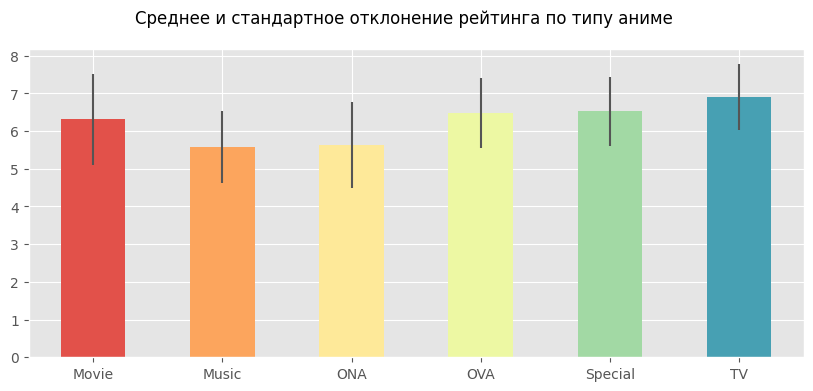

In [97]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
fig.suptitle("Среднее и стандартное отклонение рейтинга по типу аниме")
type_ratings["mean"].plot(
    ax=ax1,
    kind="bar",
    color=sns.palettes.mpl_palette("Spectral"),
    yerr=type_ratings["std"],
)
ax1.set_xticklabels(type_ratings["type"])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

for text in ax1.texts:
    text.set_visible(False)


## 3. Посчитайте и визуализируйте средний рейтинг и стандартное отклонение по жанрам. (1 балл)
График постройте для топ-15 жанров по рейтингу

In [98]:
# Группировка по жанрам и расчет среднего рейтинга и стандартного отклонения
genre_ratings = (
    df_genre_str.groupby("genre")["rating"].agg(["mean", "std"]).reset_index()
)

# Сортировка жанров по среднему рейтингу
top_15_genres = genre_ratings.sort_values("mean", ascending=False).head(15)

top_15_genres.head(3)

,genre,mean,std
12,Josei,7.443077,0.774745
37,Thriller,7.382326,1.087528
19,Mystery,7.254219,0.832180


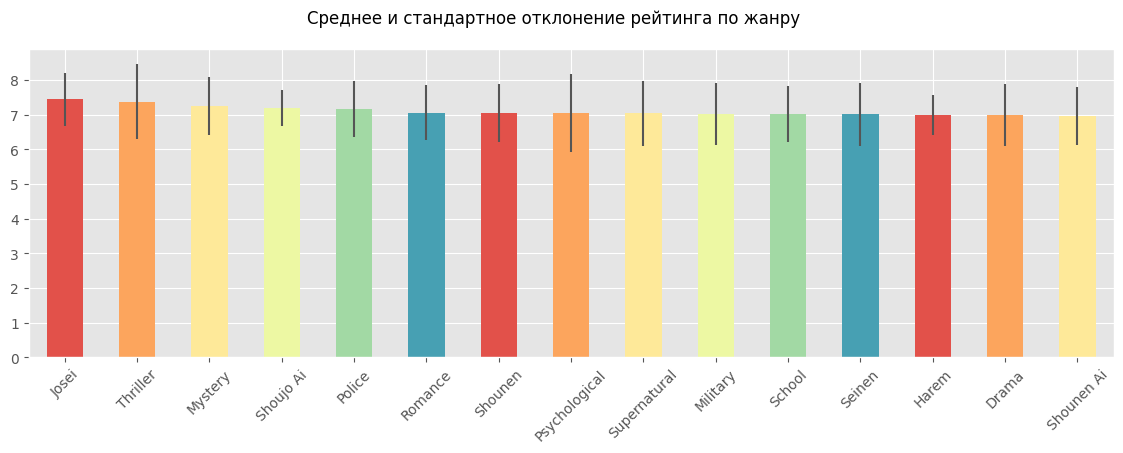

In [99]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))
fig.suptitle("Среднее и стандартное отклонение рейтинга по жанру")
top_15_genres["mean"].plot(
    ax=ax1,
    kind="bar",
    color=sns.palettes.mpl_palette("Spectral"),
    yerr=top_15_genres["std"],
)
ax1.set_xticklabels(top_15_genres["genre"])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

for text in ax1.texts:
    text.set_visible(False)

## 4. Посчитайте и визуализируйте квартили Q1, Q2 и Q3 с интерквантильным размахом по жанрам genre и типу аниме type. (1 балл)

In [100]:
df_type_pivot = df[["type", "rating"]].pivot(columns="type", values="rating")

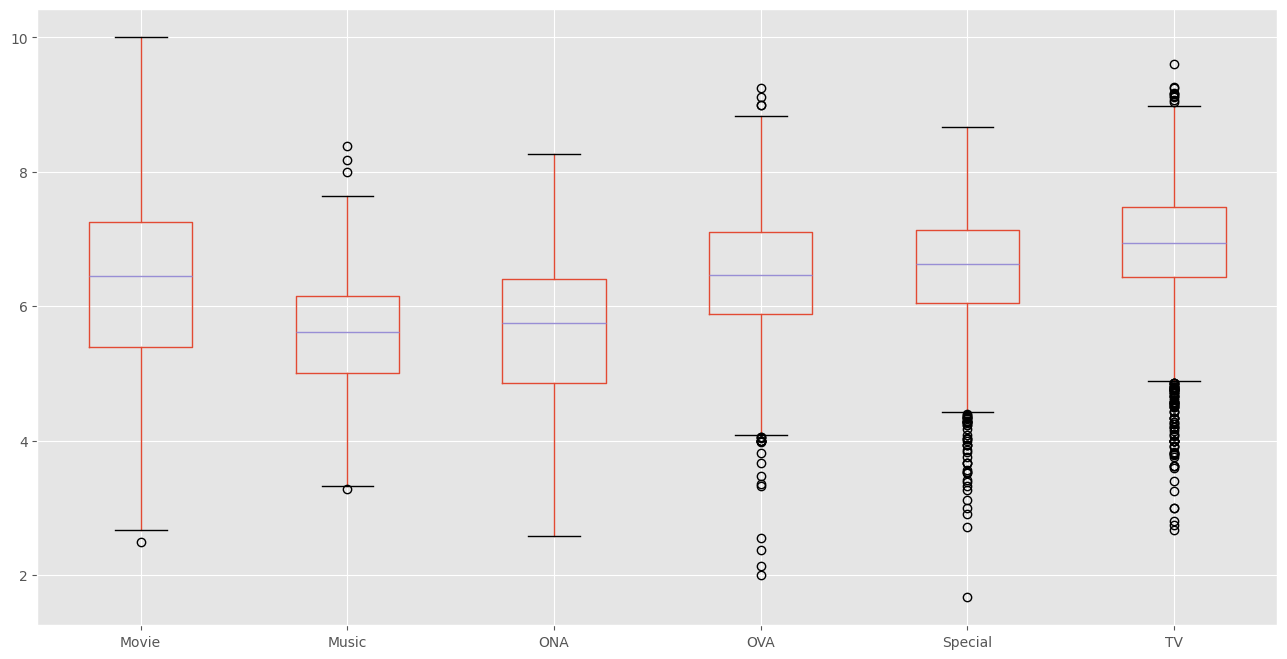

In [101]:
# Визуализация дангых по type
ax = df_type_pivot.boxplot(column=list(df_type_pivot.columns[1:]), figsize=(16, 8))

In [102]:
# Преобразование дангых по genre
df_type_genre = df_genre_str.reset_index()[["genre", "rating"]].pivot(
    columns="genre", values="rating"
)

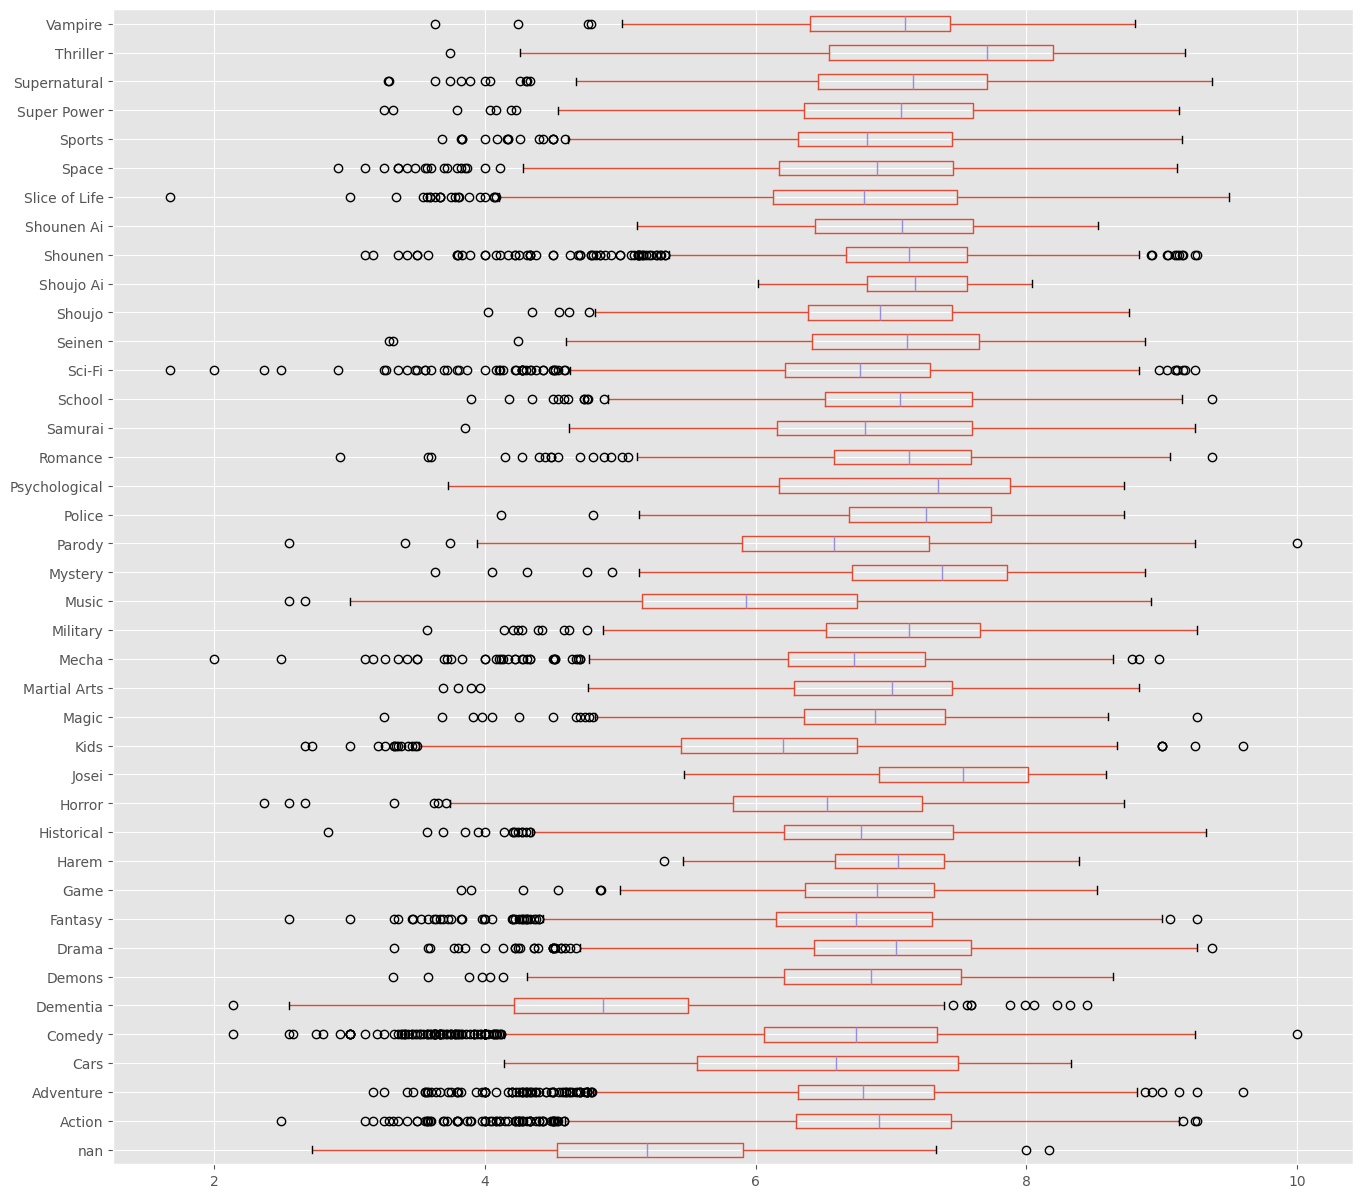

In [103]:
# Визуализация дангых по genre
ax = df_type_genre.boxplot(
    column=list(df_type_genre.columns), figsize=(16, 15), vert=False
)

## 5. Насколько часто встречаются аниме с одним или двумя жанрами? (1 балл)

In [104]:
# Подсчет уникальных жанров для каждого названия
unique_genres = df_genre_str.groupby("name")["genre"].nunique().reset_index()

# Количество аниме
count_name = unique_genres.shape[0]

In [105]:
count_genre_1 = (unique_genres["genre"] == 1).sum()
count_genre_2 = (unique_genres["genre"] == 2).sum()

print(f"Количество name с genre равным 1: {count_genre_1}")
print(f"Количество name с genre равным 2: {count_genre_2}")

Количество name с genre равным 1: 1955
Количество name с genre равным 2: 2479


## 6. Сколько в среднем эпизодов приходится на аниме типа == TV? (1 балл)

In [106]:
# Фильтрафия аниме типа TV
tv_series = df[df["type"] == "TV"]

# Подсчет среднего
avg_episodes_tv = tv_series["episodes"].mean()

print(f"Среднее количество эпизодов для типа == TV: {round(avg_episodes_tv)}")

Среднее количество эпизодов для типа == TV: 35


## 7. По правилу трех сигм на столбцах episodes, rating и members оцените кол-во аномалий. (1 балл)
если по одному из столбцов аниме не попадает в интервал трех сигм, то оно считается аномальным


In [107]:
# Подсчет среднего и стандартного отклонения
avg_episodes = np.mean(df["episodes"])
std_episodes = np.std(df["episodes"])

avg_rating = np.mean(df["rating"])
std_rating = np.std(df["rating"])

avg_members = np.mean(df["members"])
std_members = np.std(df["members"])

In [108]:
# Определение интервала трех сигм
lower_bound_episodes = avg_episodes - 3 * std_episodes
upper_bound_episodes = avg_episodes + 3 * std_episodes

lower_bound_rating = avg_rating - 3 * std_rating
upper_bound_rating = avg_rating + 3 * std_rating

lower_bound_members = avg_members - 3 * std_members
upper_bound_members = avg_members + 3 * std_members

In [109]:
# Фильтрация и подсчет аномальных значений
anomalies_episodes = len(df[df["episodes"] < lower_bound_episodes]) + len(
    df[df["episodes"] > upper_bound_episodes]
)
anomalies_rating = len(df[df["rating"] < lower_bound_rating]) + len(
    df[df["rating"] > upper_bound_rating]
)
anomalies_members = len(df[df["members"] < lower_bound_members]) + len(
    df[df["members"] > upper_bound_members]
)

print(f"Количество аномалий в столбце episodes: {anomalies_episodes}")
print(f"Количество аномалий в столбце rating: {anomalies_rating}")
print(f"Количество аномалий в столбце members: {anomalies_members}")
print(f"Всего аномалий: {anomalies_episodes + anomalies_rating + anomalies_members}")

Количество аномалий в столбце episodes: 65
Количество аномалий в столбце rating: 41
Количество аномалий в столбце members: 218
Всего аномалий: 324


## 8. Оцените и визуализируйте корреляцию среднего рейтинга жанра со средними кол-вом эпизодов и кол-вом подписчиков. (1 балл)

In [110]:
mean_genre_rating = (
    df_genre_str.groupby("genre")
    .agg({"rating": "mean", "episodes": "mean", "members": "mean"})
    .reset_index()
)

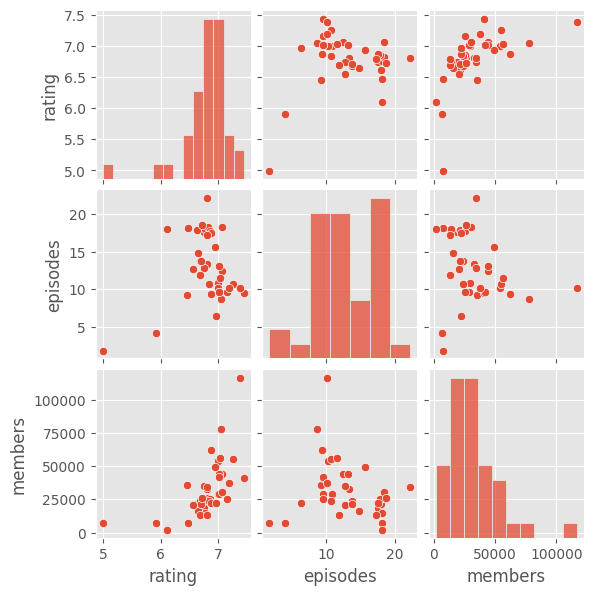

In [111]:
ax = sns.pairplot(mean_genre_rating, height=2, kind="scatter")

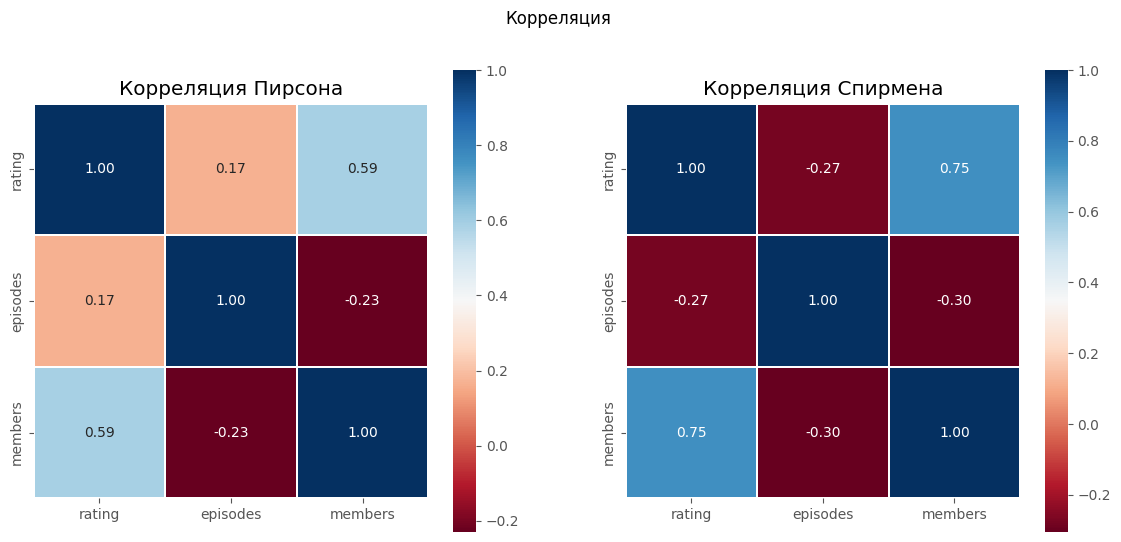

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Корреляция")
ax1 = sns.heatmap(
    mean_genre_rating.corr(method="pearson", numeric_only=True),
    ax=ax1,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax1 = ax1.set_title("Корреляция Пирсона")
ax2 = sns.heatmap(
    mean_genre_rating.corr(method="spearman", numeric_only=True),
    ax=ax2,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax2 = ax2.set_title("Корреляция Спирмена")

## 9. Оцените и визуализируйте корреляцию кол-ва жанров у аниме с его рейтингом и кол-вом подписчиков по каждому типу аниме type. (1 балл)

In [113]:
cor_genre = (
    df_genre_str.groupby(["name", "type"])
    .agg(
        {
            "genre": "count",
            "rating": "mean",
            "members": "sum",
        }
    )
    .reset_index()
)

cor_genre = cor_genre[["genre", "rating", "members"]]

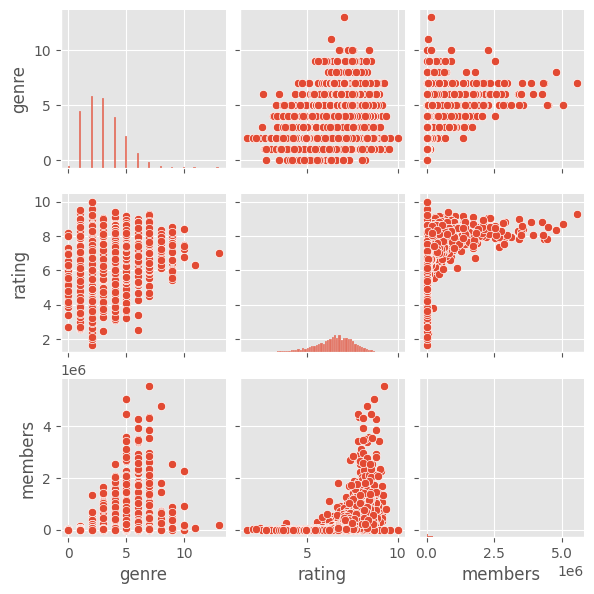

In [114]:
ax = sns.pairplot(cor_genre, height=2, kind="scatter")

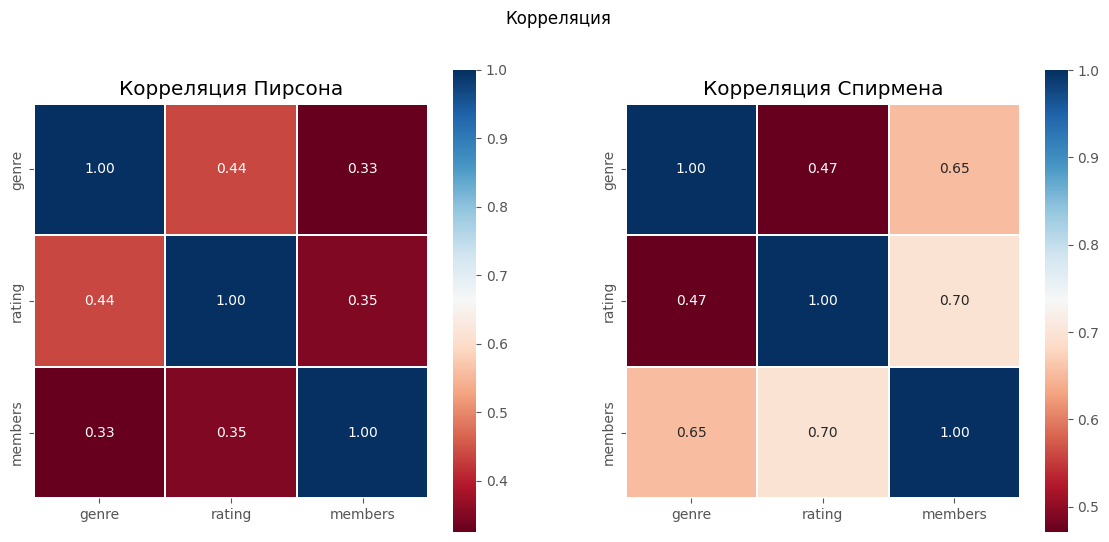

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Корреляция")
ax1 = sns.heatmap(
    cor_genre.corr(method="pearson", numeric_only=True),
    ax=ax1,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax1 = ax1.set_title("Корреляция Пирсона")
ax2 = sns.heatmap(
    cor_genre.corr(method="spearman", numeric_only=True),
    ax=ax2,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax2 = ax2.set_title("Корреляция Спирмена")

## 10. Оцените и визуализируйте корреляцию длины названия аниме name с его рейтингом, кол-вом жанров, эпизодов и подписчиков. (1 балл)

In [116]:
# Добавление столбца с длиной названия аниме
df_count_name = df_genre_str.copy()

df_count_name["name_count"] = df_count_name["name"].apply(len)

In [117]:
cor_name = (
    df_count_name.groupby("name")
    .agg(
        {
            "name_count": "mean",
            "rating": "mean",
            "genre": "count",
            "episodes": "sum",
            "members": "sum",
        }
    )
    .reset_index()
)

cor_name = cor_name[["name_count", "rating", "genre", "episodes", "members"]]

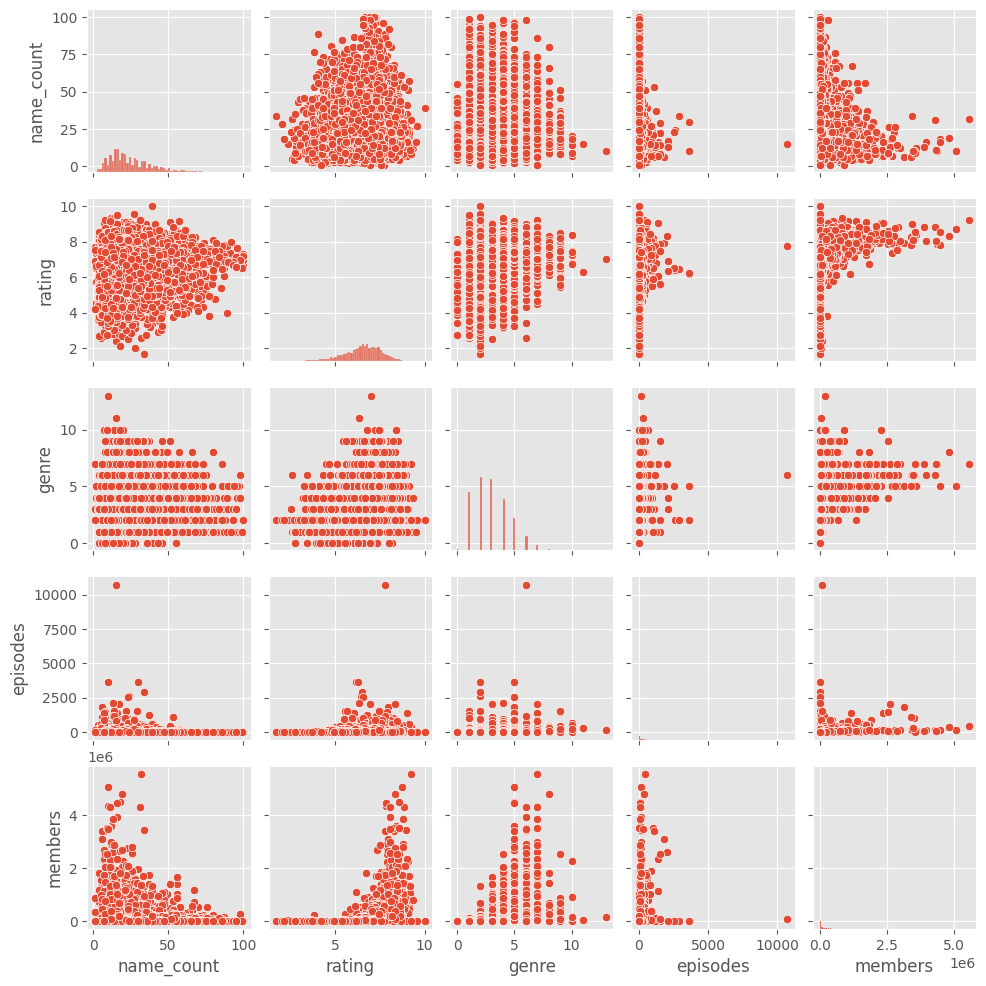

In [118]:
ax = sns.pairplot(cor_name, height=2, kind="scatter")

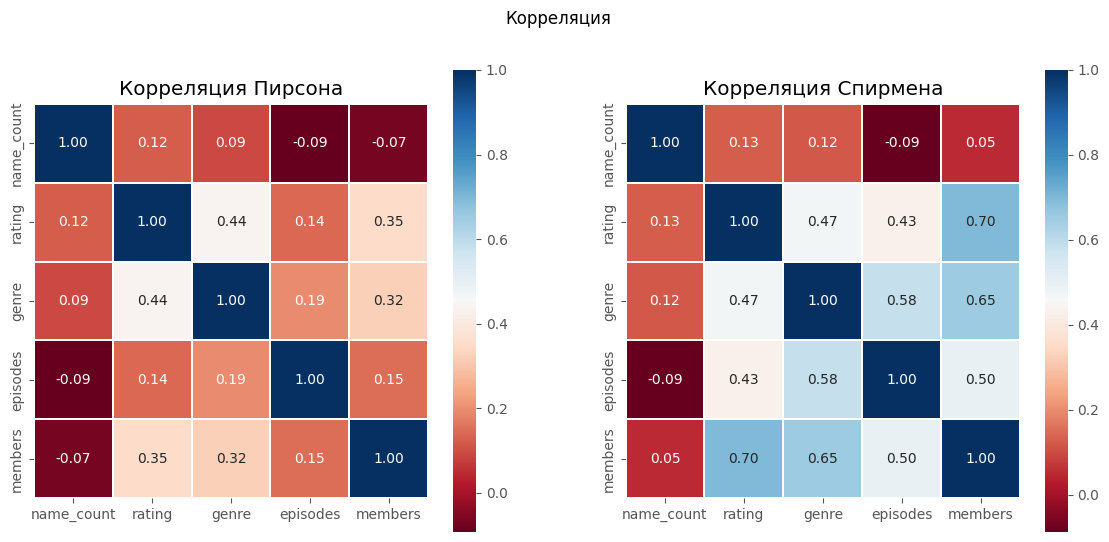

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Корреляция")
ax1 = sns.heatmap(
    cor_name.corr(method="pearson", numeric_only=True),
    ax=ax1,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax1 = ax1.set_title("Корреляция Пирсона")
ax2 = sns.heatmap(
    cor_name.corr(method="spearman", numeric_only=True),
    ax=ax2,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="RdBu",
)
ax2 = ax2.set_title("Корреляция Спирмена")

# 2. Часть

Каждое задание оценивается 1 баллом в случае полного выполнения

 ### Задание 11: Нормальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов с нормальным распределением, где среднее  μ=5 и стандартное отклонение σ=1.5. \
Описательная статистика \
Рассчитайте выборочное среднее, выборочную медиану, выборочную моду и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими. \
Анализ отклонений \
Рассчитайте частоту значений, которые отклоняются от среднего на более чем одно стандартное отклонение, и сравните это с теоретическим результатом для нормального распределения.

In [36]:
# Генерация данных
mu = 5
sigma = 1.5

sample_norm = norm.rvs(mu, sigma, size=1000)

In [37]:
# Описательная статистика
mean_norm = np.mean(sample_norm)
median_norm = np.median(sample_norm)
mode_norm = mode(sample_norm)[0]
std_norm = np.std(sample_norm)

print(f"Выборочное среднее: {mean_norm:.2f}")
print(f"Выборочная медиана: {median_norm:.2f}")
print(f"Выборочная мода: {mode_norm:.2f}")
print(f"Выборочное стандартное отклонение: {std_norm:.2f}")

Выборочное среднее: 5.00
Выборочная медиана: 4.94
Выборочная мода: -1.40
Выборочное стандартное отклонение: 1.56


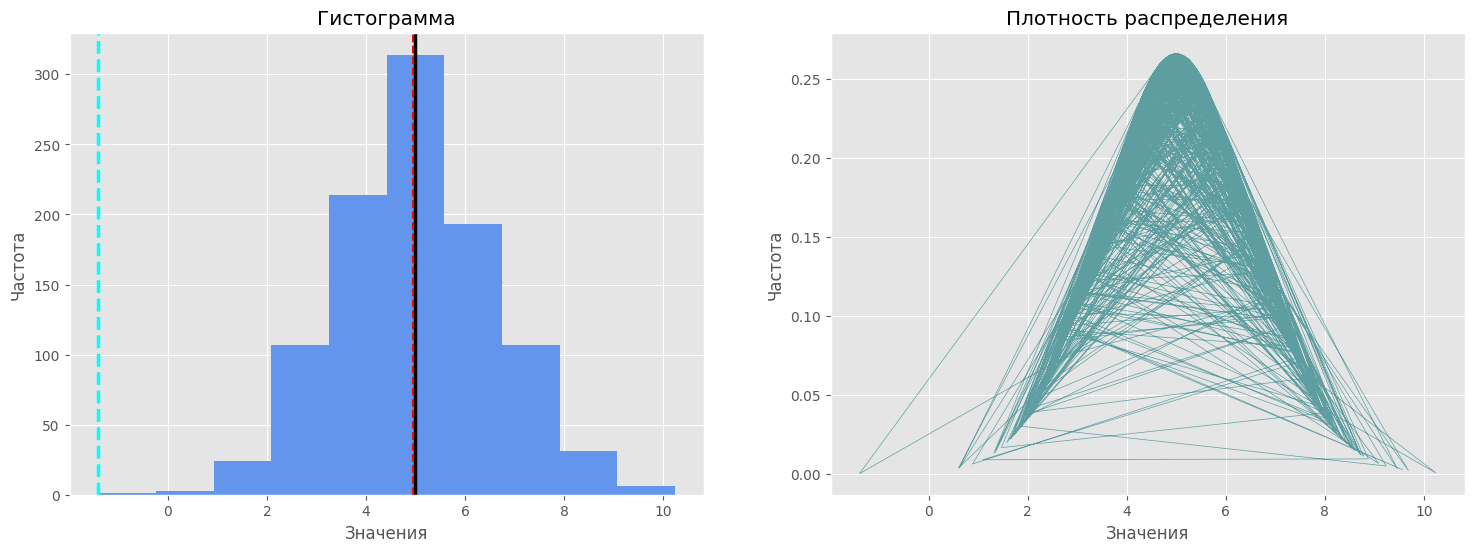

In [38]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_norm, bins=10, color="cornflowerblue")
plt.axvline(mean_norm, c="black", ls="-", lw=2.5)
plt.axvline(median_norm, c="red", ls="--", lw=1.5)
plt.axvline(mode_norm, c="aqua", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(
    sample_norm, norm.pdf(sample_norm, mu, sigma), linewidth=0.5, color="cadetblue"
)
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [39]:
# Анализ отклонений
sample_deviations = np.abs(sample_norm - mu) > sigma
sample_deviation_freq = np.sum(sample_deviations) / 1000

# Сравнение с теоретическим результатом
theoretical_deviation_freq = 1 - np.sqrt(2 * np.pi) * sigma * np.exp(
    -(mu**2) / (2 * sigma**2)
)

print(
    f"Частота отклонений от среднего на более чем одно стандартное отклонение: {sample_deviation_freq:.2f}"
)
print(
    f"Теоретическая частота отклонений от среднего на более чем одно стандартное отклонение: {theoretical_deviation_freq:.2f}"
)

Частота отклонений от среднего на более чем одно стандартное отклонение: 0.34
Теоретическая частота отклонений от среднего на более чем одно стандартное отклонение: 0.99


### Задание 12: Экспоненциальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 элементов из экспоненциального распределения с параметром λ=0.5. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление \
Постройте гистограмму и график плотности распределения. \
Анализ распределения \
Определите долю значений в выборке, которые больше двух выборочных средних, и сравните это с теоретической вероятностью для экспоненциального распределения.

In [40]:
# Генерация данных
lam = 0.5

sample_exp = expon.rvs(scale=1 / lam, size=1000)

In [41]:
# Описательная статистика
mean_exp = np.mean(sample_exp)
median_exp = np.median(sample_exp)
std_exp = np.std(sample_exp)

print(f"Выборочное среднее: {mean_exp:.2f}")
print(f"Медиана: {median_exp:.2f}")
print(f"Стандартное отклонение: {std_exp:.2f}")

Выборочное среднее: 2.02
Медиана: 1.39
Стандартное отклонение: 1.99


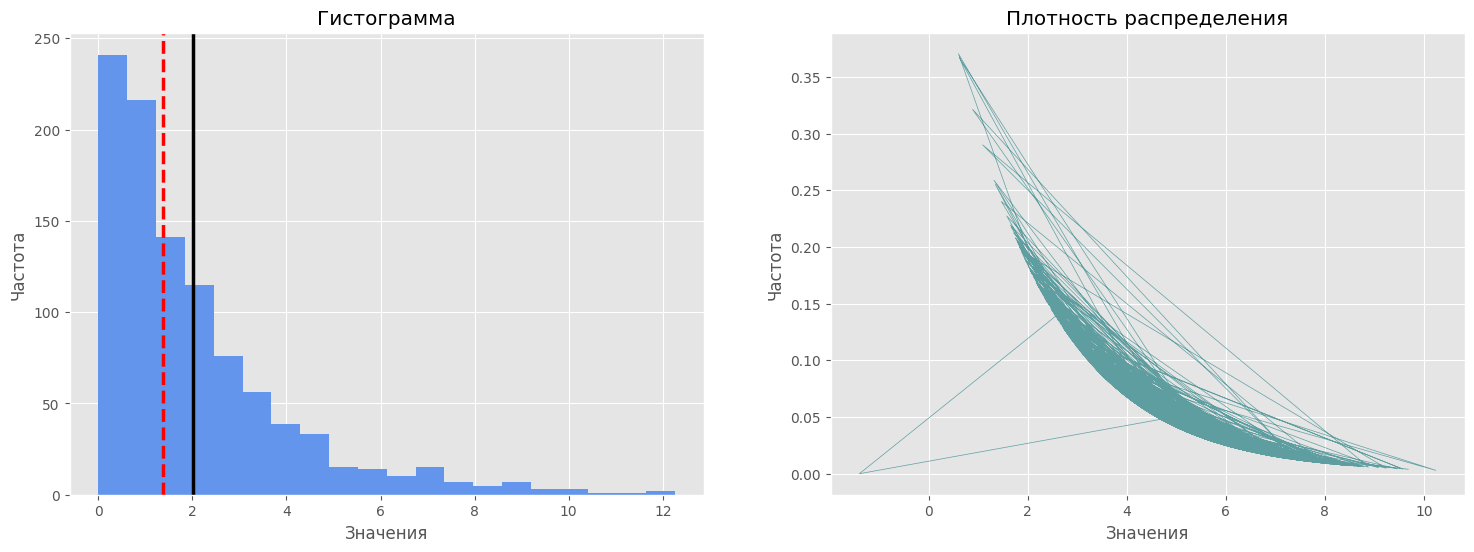

In [42]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_exp, bins=20, color="cornflowerblue")
plt.axvline(mean_exp, c="black", ls="-", lw=2.5)
plt.axvline(median_exp, c="red", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(
    sample_norm, expon.pdf(sample_norm, scale=1 / lam), linewidth=0.5, color="cadetblue"
)
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [43]:
# Анализ распределения
greater_than_mean = np.sum(sample_exp > 2 * mean_exp) / 1000
print(f"Доля значений больше двух выборочных средних: {greater_than_mean:.2f}")

# Теоретическая вероятность
theoretical_probability = 1 - np.exp(-2 * lam)
print(
    f"Теоретическая вероятность для экспоненциального распределения: {theoretical_probability:.2f}"
)

Доля значений больше двух выборочных средних: 0.13
Теоретическая вероятность для экспоненциального распределения: 0.63



### Задание 13: Биномиальное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из биномиального распределения с параметрами  n=10 и p=0.7 \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества успехов. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества успехов. \
Анализ вероятностей \
Вычислите вероятность того, что количество успехов будет больше 8, используя как выборочные данные, так и теоретическую вероятность биномиального распределения. Сравните результаты.

In [44]:
# Генерация данных
n = 10
p = 0.7

sample_binom = binom.rvs(n, p, size=1000)

In [45]:
# Описательная статистика
mean_binom = np.mean(sample_binom)
variance_binom = np.var(sample_binom)
mode_binom = mode(sample_binom)[0]

print(f"Выборочное среднее: {mean_binom:.2f}")
print(f"Дисперсия: {variance_binom:.2f}")
print(f"Мода: {mode_binom:.2f}")

Выборочное среднее: 6.96
Дисперсия: 2.05
Мода: 7.00


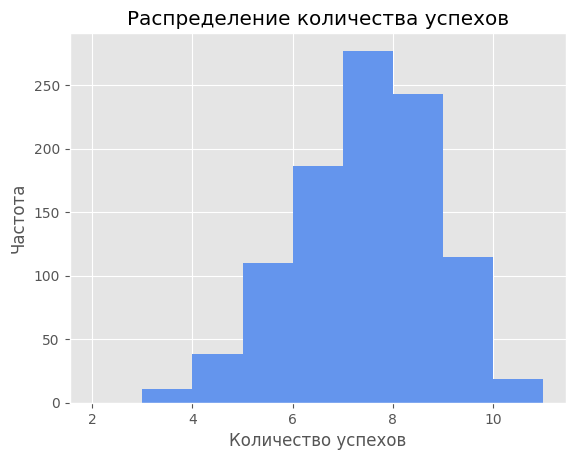

In [46]:
# Графическое представление
plt.hist(sample_binom, bins=np.arange(2, 12), color="cornflowerblue")
plt.title("Распределение количества успехов")
plt.xlabel("Количество успехов")
plt.ylabel("Частота")

plt.show()

In [47]:
# Анализ вероятностей
theoretical_probability = binom.pmf(8, n, p)
sample_probability = sum(sample_binom > 8) / 1000


print(f"Вероятность по выборке: {sample_probability:.2f}")
print(f"Теоретическая вероятность: {theoretical_probability:.2f}")

Вероятность по выборке: 0.13
Теоретическая вероятность: 0.23


### Задание 14: Геометрическое распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из геометрического распределения с вероятностью успеха p=0.3. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и моду количества попыток до первого успеха. \
Графическое представление \
Постройте гистограмму распределения количества попыток. \
Анализ вероятностей \
Определите вероятность того, что потребуется не более 5 попыток для первого успеха, используя как выборочные данные, так и теоретическое геометрическое распределение. Сравните результаты.

In [48]:
# Генерация данных
p = 0.3

sample_geom = geom.rvs(p, size=1000)

In [49]:
# Описательная статистика
mean_geom = np.mean(sample_geom)
median_geom = np.median(sample_geom)
mode_geom = mode(sample_geom)[0]

print(f"Выборочное среднее: {mean_geom:.2f}")
print(f"Медиана: {median_geom:.2f}")
print(f"Мода: {mode_geom:.2f}")

Выборочное среднее: 3.41
Медиана: 3.00
Мода: 1.00


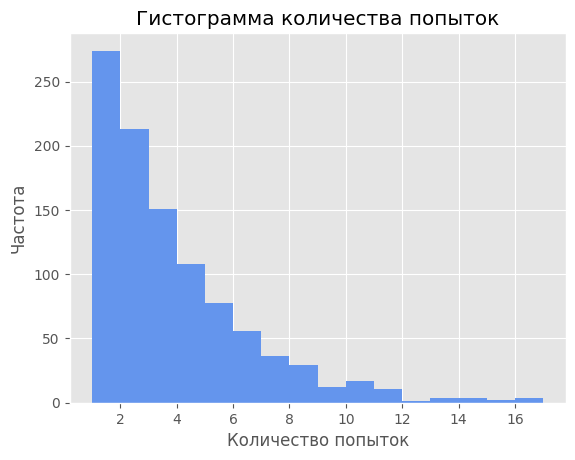

In [50]:
# Графическое представление
plt.hist(
    sample_geom,
    bins=np.arange(sample_geom.min(), sample_geom.max() + 1),
    color="cornflowerblue",
)
plt.title("Гистограмма количества попыток")
plt.xlabel("Количество попыток")
plt.ylabel("Частота")

plt.show()

In [51]:
# Анализ вероятностей
probability_5_attempts = sum(sample_geom <= 5) / n

# Теоретическая вероятность
theoretical_probability = p * (1 - p) ** 4

print(f"Вероятность не более 5 попыток (выборочная): {probability_5_attempts:.2f}")
print(f"Вероятность не более 5 попыток (теоретическая): {theoretical_probability:.2f}")

Вероятность не более 5 попыток (выборочная): 82.40
Вероятность не более 5 попыток (теоретическая): 0.07


### Задание 15: Равномерное распределение (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из равномерного распределения на отрезке от 3 до 7. \
Описательная статистика \
Рассчитайте выборочное среднее, медиану и стандартное отклонение. \
Графическое представление  \
Постройте гистограмму и график плотности распределения. Сравните выборочные статистики с теоретическими значениями для равномерного распределения.
Анализ крайних значений \
Определите долю значений, которые находятся ближе к границам распределения (например, больше 6 или меньше 4), и сравните с ожидаемым результатом для равномерного распределения.

In [52]:
# Генерация данных
sample_uni = uniform.rvs(loc=3, scale=4, size=1000)

In [53]:
# Описательная статистика
mean_uni = np.mean(sample_uni)
median_uni = np.median(sample_uni)
std_uni = np.std(sample_uni)

print(f"Выборочное среднее: {mean_uni:.2f}")
print(f"Медиана: {median_uni:.2f}")
print(f"Стандартное отклонение: {std_uni:.2f}")

Выборочное среднее: 5.02
Медиана: 5.03
Стандартное отклонение: 1.15


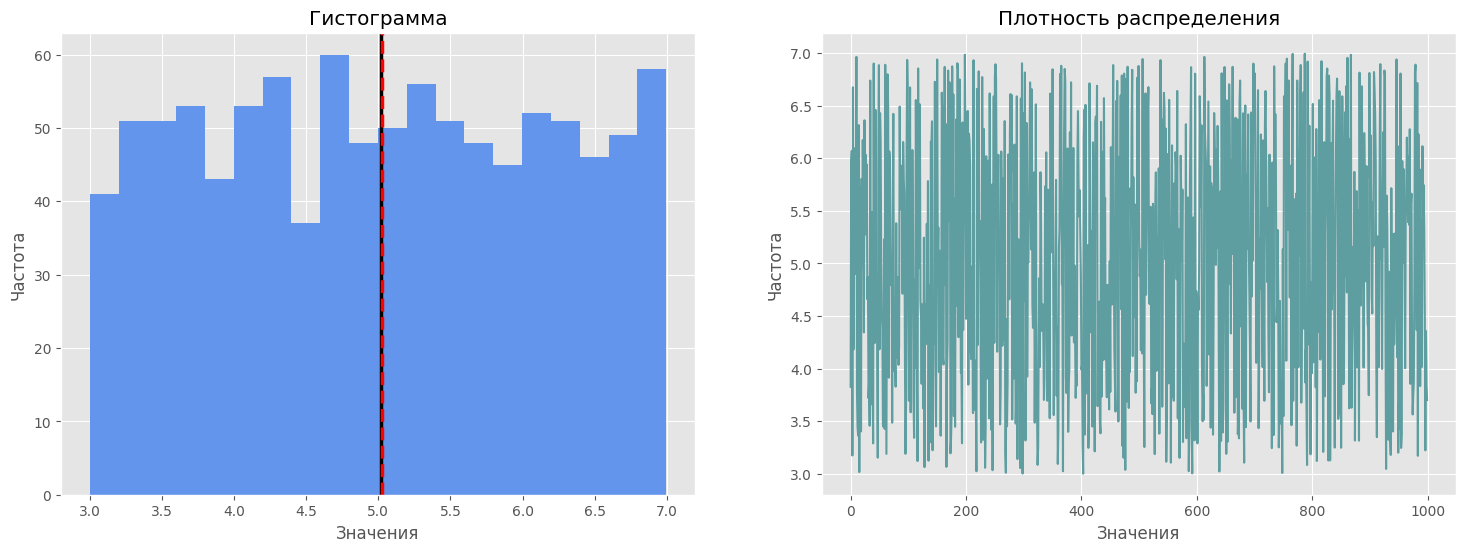

In [54]:
# Графическое представление
plt.figure(figsize=(18, 6))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(sample_uni, bins=20, color="cornflowerblue")
plt.axvline(mean_uni, c="black", ls="-", lw=2.5)
plt.axvline(median_uni, c="red", ls="--", lw=2.5)
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")

# Плотность распределения
plt.subplot(1, 2, 2)
plt.plot(sample_uni, color="cadetblue")
plt.title("Плотность распределения")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

In [55]:
# Анализ крайних значений
lower_bound = 4
upper_bound = 6
lower_count = np.sum(sample_uni < lower_bound)
upper_count = np.sum(sample_uni > upper_bound)

# Теоретические значения для равномерного распределения
lower_theoretical = (lower_bound - 3) / (7 - 3)
upper_theoretical = (upper_bound - 3) / (7 - 3)

print(f"Доля значений меньше {lower_bound}: {lower_count / 1000:.2%}")
print(f"Доля значений больше {upper_bound}: {upper_count / 1000:.2%}")
print(f"Теоретическая доля значений меньше {lower_bound}: {lower_theoretical:.2%}")
print(f"Теоретическая доля значений больше {upper_bound}: {upper_theoretical:.2%}")

Доля значений меньше 4: 23.90%
Доля значений больше 6: 25.60%
Теоретическая доля значений меньше 4: 25.00%
Теоретическая доля значений больше 6: 75.00%


### Задание 16: Распределение Пуассона (1 балл)
Генерация данных \
Сгенерируйте выборку из 1000 наблюдений из распределения Пуассона с параметром  λ=4. \
Описательная статистика \
Найдите выборочное среднее, дисперсию и моду количества событий. \
Графическое представление \
Постройте столбчатую диаграмму распределения количества событий. \
Анализ вероятностей \
Определите вероятность того, что количество событий будет меньше 3, используя как выборочные данные, так и теоретическое распределение Пуассона. Сравните результаты.

In [56]:
# Генерация данных
lam = 4

sample_poisson = poisson.rvs(lam, size=1000)

In [57]:
# Описательная статистика
mean_poisson = np.mean(sample_poisson)
var_poisson = np.var(sample_poisson)
mode_poisson = mode(sample_poisson)[0]

print(f"Выборочное среднее: {mean_poisson:.2f}")
print(f"Выборочная дисперсия: {var_poisson:.2f}")
print(f"Мода:{mode_poisson:.2f}")

Выборочное среднее: 4.06
Выборочная дисперсия: 4.12
Мода:3.00


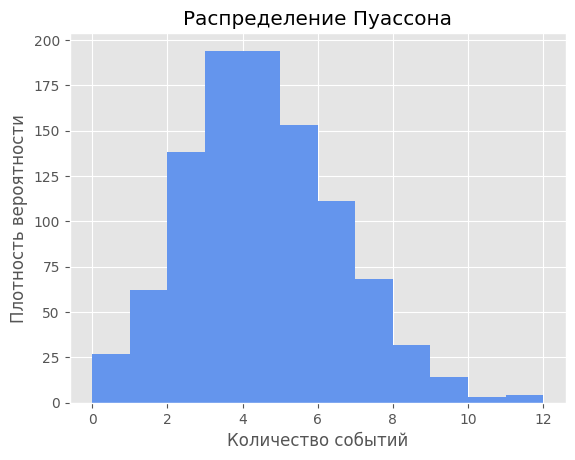

In [58]:
# Графическое представление
plt.hist(sample_poisson, bins=range(max(sample_poisson) + 1), color="cornflowerblue")
plt.title("Распределение Пуассона")
plt.xlabel("Количество событий")
plt.ylabel("Плотность вероятности")

plt.show()


In [59]:
# Анализ вероятностей
theoretical_prob = np.exp(-lam) * lam**2 / 2
sample_prob = sample_poisson.sum() / 1000

print(f"Вероятность по выборке: {sample_prob:.2f}")
print(f"Теоретическая вероятность: {theoretical_prob:.2f}")

Вероятность по выборке: 4.06
Теоретическая вероятность: 0.15


# 3 Часть

## Задание 17: Проверка несмещённости и состоятельности выборочного среднего рейтингов (3 балла все задание)
1. Вычисление генерального среднего рейтингов \
Рассчитайте выборочное среднее рейтингов всех аниме. 
2. Проверка несмещённости оценки выборочного среднего \
Сгенерируйте 1000 выборок объёма n=100 с возвращением из исходных данных.
Для каждой выборки вычислите выборочное среднее рейтингов.
Постройте гистограмму распределения полученных выборочных средних.
Вычислите среднее из выборочных средних и сравните его с генеральным средним исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочного среднего. \
Повторите шаги из пункта 2 для различных объёмов выборки: n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию выборочных средних.
Постройте график зависимости дисперсии выборочных средних от объёма выборки.
Проанализируйте, как дисперсия уменьшается с увеличением объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

In [82]:
# Вычисление генерального среднего рейтингов
mean_rating = df["rating"].mean()

print(f"Генеральное среднее рейтингов: {mean_rating:.2f}")

Генеральное среднее рейтингов: 6.49


In [83]:
# Генерация 1000 выборок объема n=100 с возвращением из исходных данных
ratings = list(df["rating"].dropna())

samples = []

for _ in range(1000):
    sample = random.sample(ratings, 100)
    samples.append(sample)

# Вычисление выборочных средних для каждой выборки
sample_means = [statistics.mean(sample) for sample in samples]

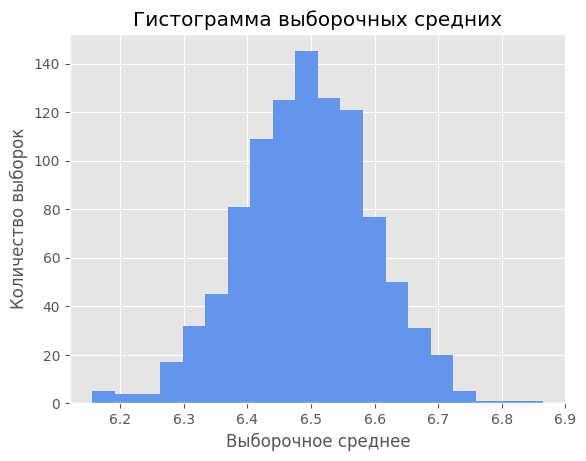

In [84]:
# Построение гистограммы распределения выборочных средних
plt.hist(sample_means, bins=20, color="cornflowerblue")
plt.title("Гистограмма выборочных средних")
plt.xlabel("Выборочное среднее")
plt.ylabel("Количество выборок")

plt.show()

In [85]:
# Вычисление среднего из выборочных средних
mean_sample_means = np.mean(sample_means)

# Сравнение среднего из выборочных средних с генеральным средним исходных данных
print(f"Среднее из выборочных средних: {mean_sample_means:.4f}")
print(f"Генеральное среднее исходных данных: {mean_rating:.4f}")

# Вывод о несмещенности оценки
if mean_sample_means == mean_rating:
    print("Оценка выборочного среднего несмещена")
else:
    print("Оценка выборочного среднего смещена")

Среднее из выборочных средних: 6.4928
Генеральное среднее исходных данных: 6.4939
Оценка выборочного среднего смещена


In [86]:
# Генерация выборок для различных объемов
sample_sizes = [50, 200, 500]

# Инициализация списков для хранения выборочных средних и дисперсий
sample_means = []
sample_variances = []

# Цикл для генерации выборок и вычисления средних и дисперсий для каждого объема выборки
for n in sample_sizes:
    samples = []
    for _ in range(1000):
        sample = random.sample(ratings, n)
        samples.append(sample)

    # Вычисление выборочных средних для каждой выборки
    sample_means.append([statistics.mean(sample) for sample in samples])

    # Вычисление дисперсии выборочных средних
    sample_variances.append(
        [statistics.variance(sample_means[i]) for i in range(len(sample_means))]
    )

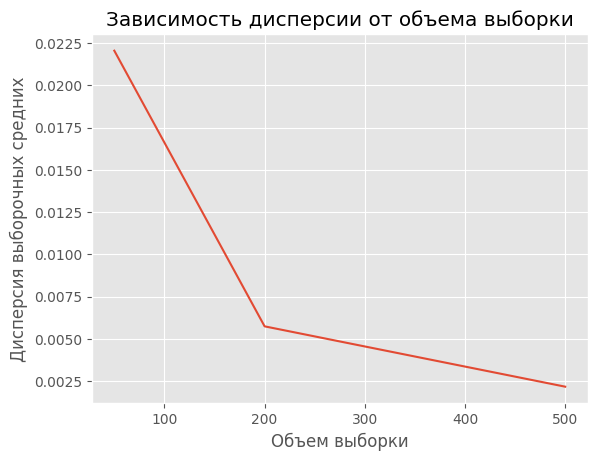

In [87]:
# Построение графика зависимости дисперсии выборочных средних от объема выборки
plt.plot(sample_sizes, sample_variances[-1])
plt.xlabel("Объем выборки")
plt.ylabel("Дисперсия выборочных средних")
plt.title("Зависимость дисперсии от объема выборки")

plt.show()

In [88]:
# Анализ и вывод
print(
    """Вывод: с увеличением объема выборки дисперсия выборочных средних уменьшается,
       что свидетельствует о состоятельности оценки выборочного среднего."""
)

Вывод: с увеличением объема выборки дисперсия выборочных средних уменьшается,
       что свидетельствует о состоятельности оценки выборочного среднего.


## Задание 18: Проверка несмещённости и состоятельности медианы рейтингов (3 балла все задание)
1. Вычисление генеральной медианы \
Рассчитайте медиану рейтингов по всему датасету.
2. Проверка несмещённости медианы \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите медиану рейтингов.
Постройте гистограмму распределения полученных медиан.
Вычислите среднее из медиан и сравните с медианой исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности медианы \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите стандартное отклонение медиан.
Постройте график зависимости стандартного отклонения медиан от объёма выборки.
Проанализируйте изменение разброса медиан с ростом объёма выборки. Сделайте вывод о состоятельности оценки. (1 балл)

In [89]:
# Вычисление генеральной медианы
median_rating = df["rating"].median()

print(f"Генеральная медиана рейтингов: {median_rating:.2f}")

Генеральная медиана рейтингов: 6.60


In [90]:
# Генерация 1000 выборок объема n=100 с возвращением из исходных данных
ratings = list(df["rating"].dropna())

samples = []

for _ in range(1000):
    sample = random.sample(ratings, 100)
    samples.append(sample)

# Вычисление медиан для каждой выборки
sample_medians = [statistics.median(sample) for sample in samples]

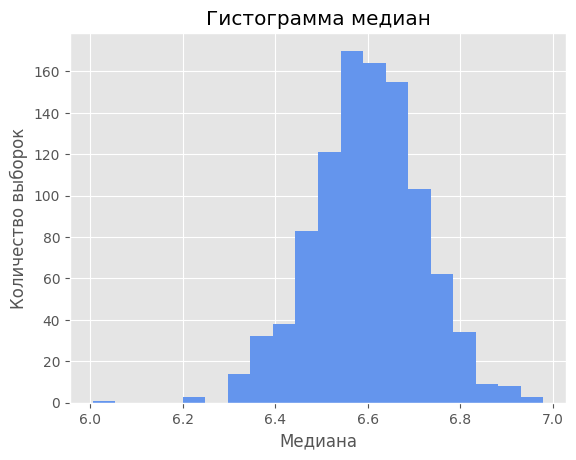

In [91]:
# Построение гистограммы распределения медиан
plt.hist(sample_medians, bins=20, color="cornflowerblue")
plt.title("Гистограмма медиан")
plt.xlabel("Медиана")
plt.ylabel("Количество выборок")

plt.show()

In [92]:
# Вычисление среднего из выборочных медиан
mean_sample_medians = np.mean(sample_medians)

# Сравнение медианы из выборочных медиан с генеральной медианой исходных данных
print(f"Среднее из выборочных медиан: {mean_sample_medians:.4f}")
print(f"Генеральная медиана исходных данных: {median_rating:.4f}")

# Вывод о несмещенности оценки
if mean_sample_medians == median_rating:
    print("Оценка выборочной медианы несмещена")
else:
    print("Оценка выборочной медианы смещена")

Среднее из выборочных медиан: 6.5990
Генеральная медиана исходных данных: 6.6000
Оценка выборочной медианы смещена


In [93]:
# Генерация выборок для различных объемов
sample_sizes = [50, 200, 500]

# Инициализация списков для хранения выборочных медиан и стандартного отклонения
sample_medians = []
sample_stds = []

# Цикл для генерации выборок и вычисления медиан и стандартного отклонения для каждого объема выборки
for n in sample_sizes:
    samples = []
    for _ in range(1000):
        sample = random.sample(ratings, n)
        samples.append(sample)

    # Вычисление медиан для каждой выборки
    sample_medians.append([statistics.median(sample) for sample in samples])

    # Вычисление стандартного отклонения выборочных медиан
    sample_stds.append(
        [statistics.stdev(sample_medians[i]) for i in range(len(sample_medians))]
    )

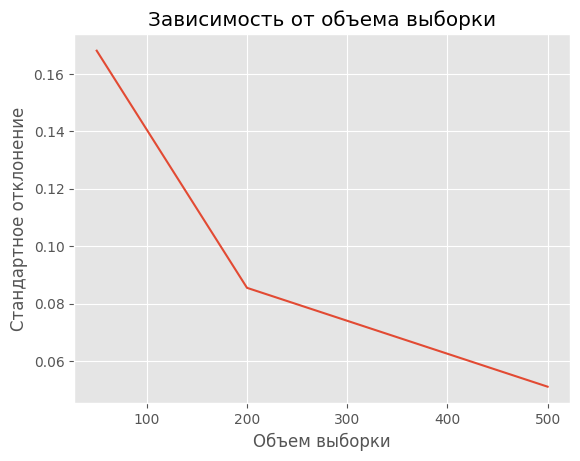

In [94]:
# Построение графика зависимости стандартного отклонения выборочных медиан от объема выборки
plt.plot(sample_sizes, sample_stds[-1])
plt.xlabel("Объем выборки")
plt.ylabel("Стандартное отклонение")
plt.title("Зависимость от объема выборки")

plt.show()

In [95]:
# Анализ и вывод
print(
    """Вывод: с увеличением объема выборки стандартное отклонение выборочных медиан уменьшается,
       что свидетельствует о состоятельности оценки выборочной медианы."""
)

Вывод: с увеличением объема выборки стандартное отклонение выборочных медиан уменьшается,
       что свидетельствует о состоятельности оценки выборочной медианы.


## Задание 19: Проверка несмещённости и состоятельности выборочной дисперсии рейтингов (3 балла все задание)
1. Вычисление выборочной дисперсии \
Рассчитайте выборочную дисперсию рейтингов по всему датасету.
2. Проверка несмещённости оценки выборочной дисперсии \
Сгенерируйте 1000 выборок объёма n=100 с возвращением.
Для каждой выборки вычислите выборочную дисперсию.
Постройте гистограмму распределения полученных дисперсий.
Вычислите среднее из дисперсий и сравните с выборочной дисперсией исходных данных. Сделайте вывод о несмещенности оценки. (1 балл)
3. Проверка состоятельности оценки выборочной дисперсии \
Повторите шаги из пункта 2 для n=50, 200, 500.
Для каждого объёма выборки вычислите дисперсию оценок выборочной дисперсии.
Постройте график зависимости дисперсии оценок выборочной дисперсии от объёма выборки.
Проанализируйте изменение разброса оценок с ростом объёма выборки.  Сделайте вывод о состоятельности оценки. (1 балл)

In [97]:
# Вычисление генеральной дисперсии
var_rating = df["rating"].var()

print(f"Генеральная дисперсия рейтингов: {var_rating:.2f}")

Генеральная дисперсия рейтингов: 1.14


In [98]:
# Генерация 1000 выборок объема n=100 с возвращением из исходных данных
ratings = list(df["rating"].dropna())

samples = []

for _ in range(1000):
    sample = random.sample(ratings, 100)
    samples.append(sample)

# Вычисление дисперсии для каждой выборки
sample_vars = [statistics.variance(sample) for sample in samples]

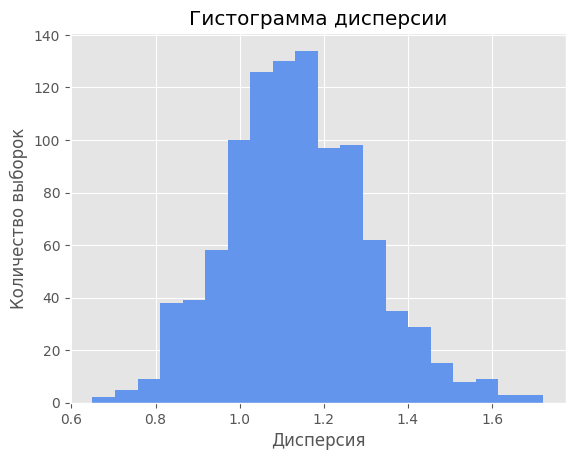

In [99]:
# Построение гистограммы распределения дисперсии
plt.hist(sample_vars, bins=20, color="cornflowerblue")
plt.title("Гистограмма дисперсии")
plt.xlabel("Дисперсия")
plt.ylabel("Количество выборок")

plt.show()

In [100]:
# Вычисление среднего из выборочных дисперсий
mean_sample_vars = np.mean(sample_vars)

# Сравнение дисперсии из выборочных дисперсий с генеральной дисперсий исходных данных
print(f"Среднее из выборочных дисперсий: {mean_sample_vars:.4f}")
print(f"Генеральная дисперсия исходных данных: {var_rating:.4f}")

# Вывод о несмещенности оценки
if mean_sample_vars == var_rating:
    print("Оценка выборочной дисперсии несмещена")
else:
    print("Оценка выборочной дисперсии смещена")

Среднее из выборочных дисперсий: 1.1376
Генеральная дисперсия исходных данных: 1.1375
Оценка выборочной дисперсии смещена


In [101]:
# Генерация выборок для различных объемов
sample_sizes = [50, 200, 500]

# Инициализация списков для хранения выборочных дисперсий и дисперсий
sample_vars = []
sample_variances = []

# Цикл для генерации выборок и вычисления выборочных дисперсий и дисперсий для каждого объема выборки
for n in sample_sizes:
    samples = []
    for _ in range(1000):
        sample = random.sample(ratings, n)
        samples.append(sample)

    # Вычисление выборочных дисперсий для каждой выборки
    sample_vars.append([statistics.variance(sample) for sample in samples])

    # Вычисление дисперсии выборочных дисперсий
    sample_variances.append(
        [statistics.variance(sample_vars[i]) for i in range(len(sample_vars))]
    )

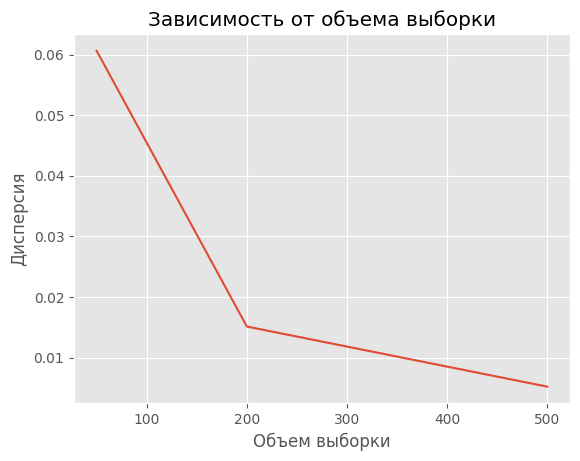

In [102]:
# Построение графика зависимости дисперсии выборочных дисперсий от объема выборки
plt.plot(sample_sizes, sample_variances[-1])
plt.xlabel("Объем выборки")
plt.ylabel("Дисперсия")
plt.title("Зависимость от объема выборки")

plt.show()

In [103]:
# Анализ и вывод
print(
    """Вывод: с увеличением объема выборки дисперсия выборочных дисперсий уменьшается,
       что свидетельствует о состоятельности оценки выборочной дисперсии."""
)

Вывод: с увеличением объема выборки дисперсия выборочных дисперсий уменьшается,
       что свидетельствует о состоятельности оценки выборочной дисперсии.
